In [1]:
file_path = "/home/sreeramv/temp/hoge/explanations/graph_Benzene_GAT_AttentionExplainer/2024-07-27-23-22-37/complexes_metrics.json"

In [2]:
import json

with open(file_path, "r") as f:
    data = json.load(f)

print(data.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [3]:
best_per_seed = []

for seed in data.keys():
    metrics = data[seed]

    # metrics is a list of dicts

    # best metric if the metric with highest "jaccard" key
    best = max(metrics, key=lambda x: x["jaccard"])

    best_per_seed.append(best)

In [6]:
# metrics look like

"""
{'accuracy': 0.5638143498363113,
  'precision': 0.11946558996558998,
  'recall': 0.0766666666666667,
  'f1': 0.0908394294507634,
  'jaccard': 0.050478243389923946,
  'auc': 0.43758185679344747,
  'prop_method': 'direct_prop',
  'alpha_c': 0,
  'alpha_e': 0}
"""

# get average, std of best_per_seed for acc, prec, recall, f1, jacc and auc

import numpy as np

metrics = ["accuracy", "precision", "recall", "f1", "jaccard", "auc"]

for metric in metrics:
    values = [best[metric] for best in best_per_seed]
    avg = np.mean(values)
    std = np.std(values)
    print(f"{metric}: {avg:.3f} +/- {std:.3f}")

accuracy: 0.531 +/- 0.114
precision: 0.134 +/- 0.063
recall: 0.089 +/- 0.035
f1: 0.102 +/- 0.044
jaccard: 0.059 +/- 0.025
auc: 0.410 +/- 0.087


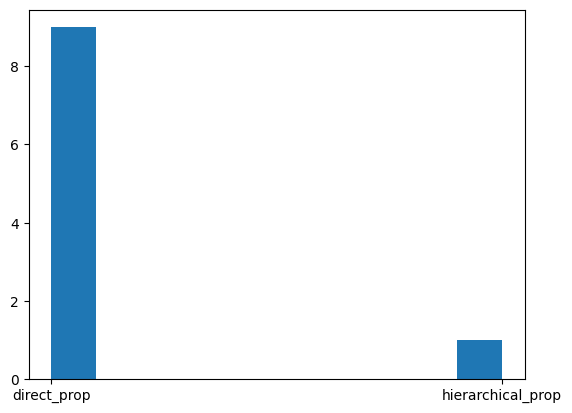

In [7]:
# plot histogram of prop_method in best runs
import matplotlib.pyplot as plt

prop_methods = [best["prop_method"] for best in best_per_seed]

plt.hist(prop_methods)
plt.show()

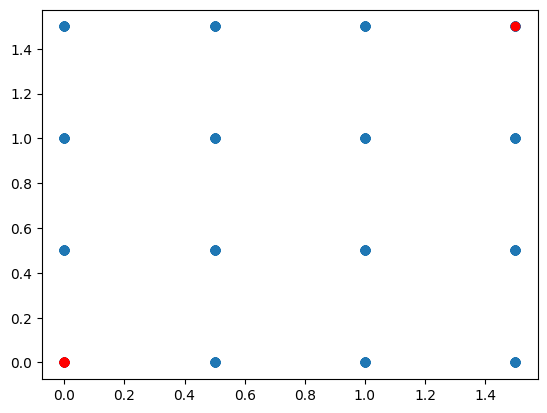

In [11]:
# each seed has 10 metrics, so we have 10*10=100 metrics in total
# get all 100 (alpha_e, alpha_c) values and plot on a 2d scatter plot
# color the 10 best (alpha_e, alpha_c) values in red

alpha_e = []
alpha_c = []

for seed in data.keys():
    metrics = data[seed]
    for metric in metrics:
        alpha_e.append(metric["alpha_e"])
        alpha_c.append(metric["alpha_c"])

plt.scatter(alpha_e, alpha_c)
plt.scatter([best["alpha_e"] for best in best_per_seed], [best["alpha_c"] for best in best_per_seed], color="red")
plt.show()